<a target="_blank" href="../cluster" style="font-size:20px">All Applications (YARN)</a>

# YARN configuration

https://hadoop.apache.org/docs/current/hadoop-yarn/hadoop-yarn-common/yarn-default.xml

In [1]:
! cat $HADOOP_HOME/etc/hadoop/yarn-site.xml

<?xml version="1.0"?>
<configuration>
    <property>
        <name>yarn.nodemanager.aux-services</name>
        <value>mapreduce_shuffle</value>
    </property>
    <property>
        <name>yarn.nodemanager.env-whitelist</name>
        <value>JAVA_HOME,HADOOP_COMMON_HOME,HADOOP_HDFS_HOME,HADOOP_CONF_DIR,CLASSPATH_PREPEND_DISTCACHE,HADOOP_YARN_HOME,HADOOP_MAPRED_HOME</value>
    </property>
    <property>
        <name>yarn.scheduler.minimum-allocation-mb</name>
        <value>1</value>
    </property>
    <property>
        <name>yarn.scheduler.maximum-allocation-mb</name>
        <value>3072</value>
    </property>
    <property>
        <name>yarn.nodemanager.resource.memory-mb</name>
        <value>3072</value>
    </property>
    <property>
        <name>yarn.log-aggregation-enable</name>
        <value>true</value>
    </property>
    <property>
        <name>yarn.resource-types.memory-mb.increment-allocation</name>
        <value>1</value>
    </property>
</configuration>


RAM usage (in MB):
- 4096 - total
- 1024 - for Data Node, Name Node, OS, etc
- 3072 - for YARN containers

In [2]:
! cat $HADOOP_HOME/etc/hadoop/yarn-site.xml | grep -A 1 mb 

        <name>yarn.scheduler.minimum-allocation-mb</name>
        <value>1</value>
--
        <name>yarn.scheduler.maximum-allocation-mb</name>
        <value>3072</value>
--
        <name>yarn.nodemanager.resource.memory-mb</name>
        <value>3072</value>
--
        <name>yarn.resource-types.memory-mb.increment-allocation</name>
        <value>1</value>


# MapReduce configuration

https://hadoop.apache.org/docs/current/hadoop-mapreduce-client/hadoop-mapreduce-client-core/mapred-default.xml

In [3]:
! cat $HADOOP_HOME/etc/hadoop/mapred-site.xml

<?xml version="1.0"?>
<?xml-stylesheet type="text/xsl" href="configuration.xsl"?>
<configuration>
    <property>
        <name>mapreduce.framework.name</name>
        <value>yarn</value>
    </property>
    <property>
        <name>mapreduce.application.classpath</name>
        <value>$HADOOP_MAPRED_HOME/share/hadoop/mapreduce/*:$HADOOP_MAPRED_HOME/share/hadoop/mapreduce/lib/*</value>
    </property>
    <property>
        <name>mapreduce.map.memory.mb</name>
        <value>512</value>
    </property>
    <property>
        <name>mapreduce.reduce.memory.mb</name>
        <value>1024</value>
    </property>
    <property>
        <name>yarn.app.mapreduce.am.resource.mb</name>
        <value>1024</value>
    </property>
    <property>
        <name>yarn.app.mapreduce.am.command-opts</name>
        <value>-Xmx819m</value>
    </property>
    <property>
        <name>mapreduce.map.speculative</name>
        <value>false</value>
    </property>
    <property>
        <name>mapreduce.reduce.

Examples of RAM usage:
- 1024 (application master) + 512 * 4 (mappers) = 3072 (total for yarn)
- 1024 (application master) + 1024 * 2 (reducers) = 3072 (total for yarn)

In [4]:
! cat $HADOOP_HOME/etc/hadoop/mapred-site.xml | grep -A 1 mb

        <name>mapreduce.map.memory.mb</name>
        <value>512</value>
--
        <name>mapreduce.reduce.memory.mb</name>
        <value>1024</value>
--
        <name>yarn.app.mapreduce.am.resource.mb</name>
        <value>1024</value>


# Wikipedia dataset

In [5]:
! ls -lh wiki

total 208M
-rw-rw-r-- 1 jovyan root  61M Nov 13 13:34 categories.jsonl
-rw-rw-r-- 1 jovyan root  387 Oct 13 07:35 README.txt
-rw-r--r-- 1 jovyan root 2.9M Apr  8 18:19 sample.jsonl
-rw-rw-r-- 1 jovyan root 144M Mar 17 01:54 wiki.jsonl


In [6]:
! head -n 1 wiki/wiki.jsonl

{"title": "April", "text": "April\n\nApril is the fourth month of the year, and comes between March and May. It is one of four months to have 30 days.\n\nApril always begins on the same day of week as July, and additionally, January in leap years. April always ends on the same day of the week as December.\n\nApril's flowers are the Sweet Pea and Daisy. Its birthstone is the diamond. The meaning of the diamond is innocence.\n\nApril comes between March and May, making it the fourth month of the year. It also comes first in the year out of the four months that have 30 days, as June, September and November are later in the year.\n\nApril begins on the same day of the week as July every year and on the same day of the week as January in leap years. April ends on the same day of the week as December every year, as each other's last days are exactly 35 weeks (245 days) apart.\n\nIn common years, April starts on the same day of the week as October of the previous year, and in leap years, May 

In [7]:
# make a sample
! head -n 1000 wiki/wiki.jsonl > wiki/sample.jsonl

# WordCount mapper

https://hadoop.apache.org/docs/current/hadoop-streaming/HadoopStreaming.html

In [8]:
%%file mapper.py
import sys
import json
import re
import string

for line in sys.stdin:
    text = json.loads(line)['text']
    text = re.sub(f'[^{re.escape(string.printable)}]', ' ', text)  # not printable to space
    words = text.lower().split()
    for word in words:
        print(word + "\t" + "1")

Overwriting mapper.py


# Testing the mapper

In [9]:
! echo "{\"text\": \"This  is  text\"}" | python ./mapper.py

this	1
is	1
text	1


# WordCount reducer

https://hadoop.apache.org/docs/current/hadoop-streaming/HadoopStreaming.html

In [10]:
# reducer input
! python -c "print('\n'.join(['aaa\t1'] * 10 + ['bbb\t1'] * 5))"

aaa	1
aaa	1
aaa	1
aaa	1
aaa	1
aaa	1
aaa	1
aaa	1
aaa	1
aaa	1
bbb	1
bbb	1
bbb	1
bbb	1
bbb	1


In [11]:
%%file reducer.py
import sys

prev_key = None
count = 0
for line in sys.stdin:  # stream is sorted by key
    key, value = line.split("\t")
    
    if prev_key is not None and key != prev_key:
        # new key in stream, dump previous
        print(prev_key + "\t" + str(count))
        count = 0
    
    count += int(value)
    prev_key = key

# dump last key
print(prev_key + "\t" + str(count))

Overwriting reducer.py


# Testing the reducer

In [12]:
! python -c "print('\n'.join(['aaa\t1'] * 10 + ['bbb\t1'] * 5))" | python ./reducer.py

aaa	10
bbb	5


# Testing MapReduce Locally

In [13]:
%%bash
cat wiki/sample.jsonl | python ./mapper.py | sort -k 1,1 -t $'\t' | python ./reducer.py > result.txt
cat result.txt | sort -k 2,2 -t $'\t' -n -r | head -n 10

the	34538
of	15944
and	12966
in	12448
a	11322
is	10870
to	9469
are	5598
it	4330
that	4057


# Copy files to HDFS

In [14]:
! hadoop fs -copyFromLocal wiki /

In [15]:
! hadoop fs -ls -h /wiki

Found 4 items
-rw-r--r--   1 jovyan supergroup        387 2023-04-08 18:19 /wiki/README.txt
-rw-r--r--   1 jovyan supergroup     60.9 M 2023-04-08 18:19 /wiki/categories.jsonl
-rw-r--r--   1 jovyan supergroup      2.9 M 2023-04-08 18:19 /wiki/sample.jsonl
-rw-r--r--   1 jovyan supergroup    143.4 M 2023-04-08 18:19 /wiki/wiki.jsonl


# Run on a Hadoop cluster

https://hadoop.apache.org/docs/current/hadoop-streaming/HadoopStreaming.html

https://hadoop.apache.org/docs/current/hadoop-streaming/HadoopStreaming.html#Packaging_Files_With_Job_Submissions

In [16]:
! /usr/bin/python3.6 -c "import numpy"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'numpy'


In [17]:
! /opt/conda/bin/python3.6 -c "import numpy"

In [18]:
! hadoop fs -rm -r /word-count

! mapred streaming \
  -input /wiki/sample.jsonl \
  -output /word-count \
  -mapper "/opt/conda/bin/python3.6 mapper.py" \
  -reducer "/opt/conda/bin/python3.6 reducer.py" \
  -file mapper.py \
  -file reducer.py

rm: `/word-count': No such file or directory
2023-04-08 18:19:57,807 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [mapper.py, reducer.py] [/usr/local/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.4.jar] /tmp/streamjob6296674256803778369.jar tmpDir=null
2023-04-08 18:19:58,612 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at /0.0.0.0:8032
2023-04-08 18:19:58,789 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at /0.0.0.0:8032
2023-04-08 18:19:59,043 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/jovyan/.staging/job_1680545577204_0001
2023-04-08 18:19:59,373 INFO mapred.FileInputFormat: Total input files to process : 1
2023-04-08 18:19:59,431 INFO mapreduce.JobSubmitter: number of splits:2
2023-04-08 18:19:59,538 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1680545577204_0001
2023-04-08 18:19:5

In [19]:
! hadoop fs -ls /word-count

Found 2 items
-rw-r--r--   1 jovyan supergroup          0 2023-04-08 18:20 /word-count/_SUCCESS
-rw-r--r--   1 jovyan supergroup     522039 2023-04-08 18:20 /word-count/part-00000


In [20]:
%%bash
hadoop fs -cat "/word-count/*" | sort -k 2,2 -t $'\t' -n -r | head -n 10

the	34538
of	15944
and	12966
in	12448
a	11322
is	10870
to	9469
are	5598
it	4330
that	4057


# Catching an error in mapper

In [21]:
%%file mapper.py
import sys
import json
import re
import string

for line in sys.stdin:
    text = json.loads(line)['text123']  # error: missing key!
    text = re.sub(f'[^{re.escape(string.printable)}]', ' ', text)  # not printable to space
    words = text.lower().split()
    for word in words:
        print(word + "\t" + "1")

Overwriting mapper.py


In [22]:
! hadoop fs -rm -r /word-count

! mapred streaming \
  -input /wiki/sample.jsonl \
  -output /word-count \
  -mapper "/opt/conda/bin/python3.6 mapper.py" \
  -reducer "/opt/conda/bin/python3.6 reducer.py" \
  -file mapper.py \
  -file reducer.py

Deleted /word-count
2023-04-08 18:20:51,494 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [mapper.py, reducer.py] [/usr/local/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.4.jar] /tmp/streamjob567827242542893164.jar tmpDir=null
2023-04-08 18:20:53,065 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at /0.0.0.0:8032
2023-04-08 18:20:53,412 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at /0.0.0.0:8032
2023-04-08 18:20:53,898 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/jovyan/.staging/job_1680545577204_0002
2023-04-08 18:20:54,826 INFO mapred.FileInputFormat: Total input files to process : 1
2023-04-08 18:20:55,108 INFO mapreduce.JobSubmitter: number of splits:2
2023-04-08 18:20:55,477 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1680545577204_0002
2023-04-08 18:20:55,477 INFO mapreduce.JobSu

2023-04-08 18:21:31,082 INFO mapreduce.Job: Counters: 14
	Job Counters 
		Failed map tasks=7
		Killed map tasks=1
		Killed reduce tasks=1
		Launched map tasks=8
		Other local map tasks=6
		Data-local map tasks=2
		Total time spent by all maps in occupied slots (ms)=14271488
		Total time spent by all reduces in occupied slots (ms)=0
		Total time spent by all map tasks (ms)=27874
		Total vcore-milliseconds taken by all map tasks=27874
		Total megabyte-milliseconds taken by all map tasks=14271488
	Map-Reduce Framework
		CPU time spent (ms)=0
		Physical memory (bytes) snapshot=0
		Virtual memory (bytes) snapshot=0
2023-04-08 18:21:31,082 ERROR streaming.StreamJob: Job not successful!
Streaming Command Failed!


# Catching an error in reducer

In [23]:
%%file mapper.py
import sys
import json
import re
import string

for line in sys.stdin:
    text = json.loads(line)['text']
    text = re.sub(f'[^{re.escape(string.printable)}]', ' ', text)  # not printable to space
    words = text.lower().split()
    for word in words:
        print(word + "\n" + "1")  # error: reducer will fail!

Overwriting mapper.py


In [24]:
! hadoop fs -rm -r /word-count

! mapred streaming \
  -input /wiki/sample.jsonl \
  -output /word-count \
  -mapper "/opt/conda/bin/python3.6 mapper.py" \
  -reducer "/opt/conda/bin/python3.6 reducer.py" \
  -file mapper.py \
  -file reducer.py

Deleted /word-count
2023-04-08 18:22:32,216 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [mapper.py, reducer.py] [/usr/local/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.4.jar] /tmp/streamjob626740040326122891.jar tmpDir=null
2023-04-08 18:22:33,990 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at /0.0.0.0:8032
2023-04-08 18:22:34,349 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at /0.0.0.0:8032
2023-04-08 18:22:34,928 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/jovyan/.staging/job_1680545577204_0003
2023-04-08 18:22:36,329 INFO mapred.FileInputFormat: Total input files to process : 1
2023-04-08 18:22:36,600 INFO mapreduce.JobSubmitter: number of splits:2
2023-04-08 18:22:37,377 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1680545577204_0003
2023-04-08 18:22:37,377 INFO mapreduce.JobSu

# Catching a memory error

In [25]:
%%file mapper.py
import sys
import numpy as np

matrix = np.ones((int(2.2 * 1024 * 1024 * 1024),), dtype=np.uint8)  # 2.2GB
s = matrix.sum()

for line in sys.stdin:
    print(str(s))

Overwriting mapper.py


In [26]:
! hadoop fs -rm -r /test

! mapred streaming \
  -input /wiki/sample.jsonl \
  -output /test \
  -mapper "/opt/conda/bin/python3.6 mapper.py" \
  -file mapper.py

rm: `/test': No such file or directory
2023-04-08 18:24:21,815 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [mapper.py] [/usr/local/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.4.jar] /tmp/streamjob4417979966207050622.jar tmpDir=null
2023-04-08 18:24:22,642 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at /0.0.0.0:8032
2023-04-08 18:24:22,824 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at /0.0.0.0:8032
2023-04-08 18:24:23,046 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/jovyan/.staging/job_1680545577204_0004
2023-04-08 18:24:23,341 INFO mapred.FileInputFormat: Total input files to process : 1
2023-04-08 18:24:23,394 INFO mapreduce.JobSubmitter: number of splits:2
2023-04-08 18:24:23,517 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1680545577204_0004
2023-04-08 18:24:23,517 INFO mapredu

2023-04-08 18:24:52,403 INFO mapreduce.Job: Counters: 14
	Job Counters 
		Failed map tasks=7
		Killed map tasks=1
		Killed reduce tasks=1
		Launched map tasks=8
		Other local map tasks=6
		Data-local map tasks=2
		Total time spent by all maps in occupied slots (ms)=14264320
		Total time spent by all reduces in occupied slots (ms)=0
		Total time spent by all map tasks (ms)=27860
		Total vcore-milliseconds taken by all map tasks=27860
		Total megabyte-milliseconds taken by all map tasks=14264320
	Map-Reduce Framework
		CPU time spent (ms)=0
		Physical memory (bytes) snapshot=0
		Virtual memory (bytes) snapshot=0
2023-04-08 18:24:52,403 ERROR streaming.StreamJob: Job not successful!
Streaming Command Failed!


In [29]:
! yarn application -kill application_*

2023-04-08 18:25:43,820 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at /0.0.0.0:8032
Exception in thread "main" java.lang.IllegalArgumentException: Invalid ApplicationId: application_*
	at org.apache.hadoop.yarn.api.records.ApplicationId.fromString(ApplicationId.java:120)
	at org.apache.hadoop.yarn.client.cli.ApplicationCLI.killApplication(ApplicationCLI.java:539)
	at org.apache.hadoop.yarn.client.cli.ApplicationCLI.killApplication(ApplicationCLI.java:519)
	at org.apache.hadoop.yarn.client.cli.ApplicationCLI.executeKillCommand(ApplicationCLI.java:1172)
	at org.apache.hadoop.yarn.client.cli.ApplicationCLI.run(ApplicationCLI.java:186)
	at org.apache.hadoop.util.ToolRunner.run(ToolRunner.java:81)
	at org.apache.hadoop.util.ToolRunner.run(ToolRunner.java:95)
	at org.apache.hadoop.yarn.client.cli.ApplicationCLI.main(ApplicationCLI.java:128)


In [28]:
! hadoop fs -rm -r /test

! mapred streaming \
  -Dmapreduce.map.memory.mb=2048 \
  -input /wiki/sample.jsonl \
  -output /test \
  -mapper "/opt/conda/bin/python3.6 mapper.py" \
  -file mapper.py

Deleted /test
2023-04-08 18:25:19,935 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [mapper.py] [/usr/local/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.4.jar] /tmp/streamjob5782894505211121380.jar tmpDir=null
2023-04-08 18:25:20,763 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at /0.0.0.0:8032
2023-04-08 18:25:20,940 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at /0.0.0.0:8032
2023-04-08 18:25:21,178 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/jovyan/.staging/job_1680545577204_0005
2023-04-08 18:25:21,487 INFO mapred.FileInputFormat: Total input files to process : 1
2023-04-08 18:25:21,534 INFO mapreduce.JobSubmitter: number of splits:2
2023-04-08 18:25:21,645 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1680545577204_0005
2023-04-08 18:25:21,645 INFO mapreduce.JobSubmitter: Executin

# HW
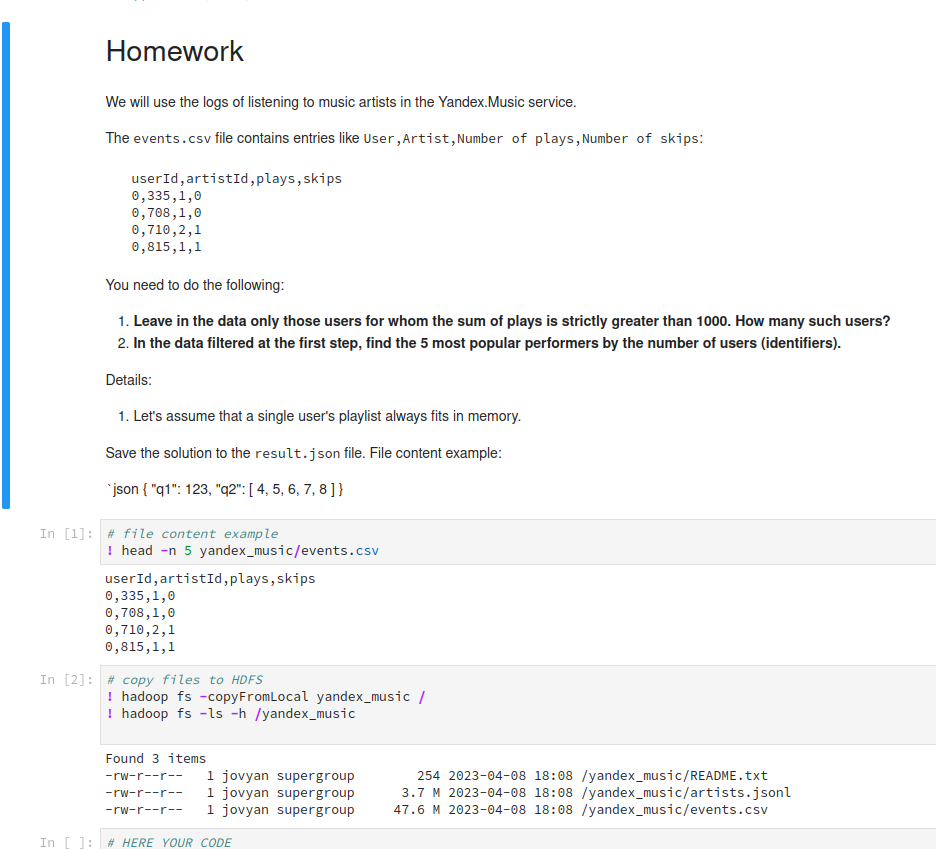

In [47]:
!head -n 5 yandex_music/events.csv

userId,artistId,plays,skips
0,335,1,0
0,708,1,0
0,710,2,1
0,815,1,1


In [75]:
! head -n 5 yandex_music/events.csv | python ./mapper2.py

0	5


In [74]:
%%file mapper2.py
import sys
import json
import re
import string


prev_key = None
count = 0
flag = 0
for line in sys.stdin:
    line = line.split(',')
    if flag == 0:
        col_names = line
        flag = 1
    else:
        key, _, plays, _ = line
        if prev_key is not None and key != prev_key:
            print(prev_key + "\t" + str(count))
            count = 0
        count += int(plays)
        prev_key = key

print(prev_key + "\t" + str(count))

Overwriting mapper2.py


In [79]:
%%file reducer2.py
import sys

count = 0
for line in sys.stdin:  # stream is sorted by key
    key, value = line.split("\t")
    if int(value) > 1000:
        count += 1

print(count)

Overwriting reducer2.py


In [80]:
%%bash
cat yandex_music/events.csv | python ./mapper2.py | python ./reducer2.py > result.txt
cat result.txt

3117


# 1. 3117

# 2 .[11368,
3629,
259,
44148,
23524]

In [105]:
!head -n 5 yandex_music/events.csv

userId,artistId,plays,skips
0,335,1,0
0,708,1,0
0,710,2,1
0,815,1,1


In [115]:
!cat yandex_music/events.csv | python ./mapper3.py

artistId
11368    2574
3629     2286
259      2208
44148    2161
23524    2110
59783    2049
21042    1925
23595    1909
21643    1902
645      1876
Name: userId, dtype: int64


In [114]:
%%file mapper3.py
import sys
import json
import re
import string

import pandas as pd


flag = 0
data = []
for line in sys.stdin:
    line = line.split(',')
    if flag == 0:
        col_names = [i.strip() for i in line]
        flag = 1
    else:
        data.append([int(i.strip()) for i in line])

df = pd.DataFrame(data, columns=col_names)
lst_userId = list(df.groupby(['userId'])['plays'].sum()[
    df.groupby(['userId'])['plays'].sum() > 1000
].reset_index().userId.values)

df = df[df.userId.isin(lst_userId)]

df_2 = df.groupby(['artistId'])['userId'].count().sort_values(ascending=False)

print(df_2.head(10))

Overwriting mapper3.py


In [97]:
pd.DataFrame.reset_index

<module 'pandas' from '/opt/conda/lib/python3.6/site-packages/pandas/__init__.py'>

In [1]:
res = {
    'q1': 3117,
    'q2':[11368,
    3629,
    259,
    44148,
    23524]
}

In [2]:
import json

In [3]:
with open('result.json', 'w') as fp:
    json.dump(res, fp)

In [5]:
!TG_USER=Bekkasik curl -F file=@result.json "51.250.54.133:80/MDS-LSML1/$TG_USER/w1/1"

1.0
Correct q1 answer! Correct q2 answer!


In [124]:
!curl -F file=@result.json "51.250.54.133:80/MDS-LSML1/Bekkasik/w1/1"

1.0
Correct q1 answer! Correct q2 answer!
